# Breast Cancer Model

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, fbeta_score
from time import time
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
cancer = load_breast_cancer()
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [20]:
df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['diagnosis'] = cancer['target']

X = df_cancer.drop(['diagnosis'],axis=1)#drop the target class from train set
y = df_cancer['diagnosis']#seperating out the target class
print(X.columns)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


In [21]:
X = X.dropna(axis=1) 

In [25]:
def model_evaluation_clf(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred), 3)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}


In [81]:
# Assuming dict_models is a dictionary of models and parameters
dict_models = {
    'SVM_Linear': {
        'model': SVC(kernel='linear', probability=True),
        'grid': {'model__C': [0.1, 1, 10]},
    },
    'SVM_Polynomial': {
        'model': SVC(kernel='poly',  probability=True),
        'grid': {'model__C': [0.1, 1, 10], 'model__degree': [2, 3, 4]},
    },
    'SVM_RBF': {
        'model': SVC(kernel='rbf',  probability=True),
        'grid': {'model__C': [0.1, 1, 10], 'model__gamma': [0.1, 1, 10]},
    },
    'SVM_Sigmoid': {
        'model': SVC(kernel='sigmoid',  probability=True),
        'grid': {'model__C': [0.1, 1, 10], 'model__gamma': [0.1, 1, 10]},
    }
}

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
confusion_matrices = {}

# Sobremuestreo de la clase minoritaria
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define la métrica personalizada con un mayor énfasis en el recall
custom_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

nb_res = 0

for model_name, config in dict_models.items():
    print(f'Training {model_name}...')
    model = config['model']
    param_grid = config['grid']
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring=custom_scorer, n_jobs=-1)
    
    start_time = time()
    clf.fit(X_train, y_train)
    end_time = time()

    print(f"Best params {model_name}: \n{clf.best_params_}")

    # Evaluation metrics
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, round(end_time - start_time, 1), accuracy, precision, recall, f1, roc_auc]
    
    # Generate confusion matrix
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    
    nb_res += 1

    print(f"CPU Time: {round(end_time - start_time, 1)}s")
    print()


Training SVM_Linear...
Best params SVM_Linear: 
{'model__C': 0.1}
CPU Time: 0.3s

Training SVM_Polynomial...
Best params SVM_Polynomial: 
{'model__C': 1, 'model__degree': 3}
CPU Time: 0.5s

Training SVM_RBF...
Best params SVM_RBF: 
{'model__C': 10, 'model__gamma': 0.1}
CPU Time: 1.1s

Training SVM_Sigmoid...
Best params SVM_Sigmoid: 
{'model__C': 0.1, 'model__gamma': 0.1}
CPU Time: 0.4s



Para el kernel lineal, el mejor parámetro encontrado fue C=0.1. En el caso del kernel polinomial, los mejores parámetros fueron C=1 y degree=3. Para el kernel RBF, los mejores parámetros fueron C=10 y gamma=0.1. Finalmente, para el kernel sigmoide, los mejores parámetros fueron C=0.1 y gamma=0.1.

Los tiempos de CPU para entrenar cada modelo variaron, siendo más rápido el entrenamiento con el kernel lineal (0.3s) y más lento con el kernel RBF (1.1s). Estos resultados sugieren que el kernel RBF tuvo el rendimiento más alto en términos de precisión de clasificación, aunque con un costo computacional más alto

El RandomOverSampler aborda este problema generando nuevas muestras sintéticas de la clase minoritaria seleccionando aleatoriamente muestras de la clase minoritaria y duplicándolas hasta que el número de muestras en la clase minoritaria alcance un cierto umbral o se iguale al número de muestras en la clase mayoritaria.

En el código proporcionado, el RandomOverSampler se utiliza después de cargar los datos (X e y) y antes de dividirlos en conjuntos de entrenamiento y prueba. Esto asegura que el conjunto de entrenamiento resultante tenga una distribución equilibrada de las clases.

In [78]:
print(results.to_string(index=False))

         Model  CPU time  Accuracy  Precision   Recall  f1-score      AUC
    SVM_Linear       0.2  0.972028   0.957746 0.985507  0.971429 0.991579
SVM_Polynomial       0.6  0.930070   0.927536 0.927536  0.927536 0.987466
       SVM_RBF       1.1  0.937063   0.954545 0.913043  0.933333 0.989816
   SVM_Sigmoid       0.5  0.951049   0.930556 0.971014  0.950355 0.983157


- Accuracy (Exactitud): Mide la proporción de predicciones correctas sobre el total de predicciones. Por ejemplo, un valor de 0.972 para SVM_Linear indica que alrededor del 97.2% de las predicciones fueron correctas para ese modelo.

- Precision (Precisión): Indica la proporción de verdaderos positivos (instancias correctamente identificadas como positivas) entre todas las instancias etiquetadas como positivas por el modelo. Un valor de 0.957 para SVM_Linear significa que alrededor del 95.7% de las instancias clasificadas como positivas fueron verdaderamente positivas.

- Recall (Recuperación o Sensibilidad): Es la proporción de verdaderos positivos entre todas las instancias positivas en los datos reales. Por ejemplo, un valor de 0.986 para SVM_Linear indica que alrededor del 98.6% de las instancias positivas en los datos reales fueron identificadas correctamente por el modelo.

- F1-score: Es la media harmónica de precision y recall. Proporciona un equilibrio entre la precisión y la recuperación. Un puntaje de 0.971 para SVM_Linear indica un buen equilibrio entre precisión y recuperación.

- AUC (Area Under the Curve): Mide la capacidad del modelo para discriminar entre clases positivas y negativas. Un valor de 0.992 para SVM_Linear sugiere que este modelo tiene una alta capacidad para distinguir entre las clases.

En general, parece que el modelo SVM_Linear tuvo el mejor rendimiento en todas las métricas evaluadas, seguido por SVM_Sigmoid, SVM_RBF y SVM_Polynomial en ese orden

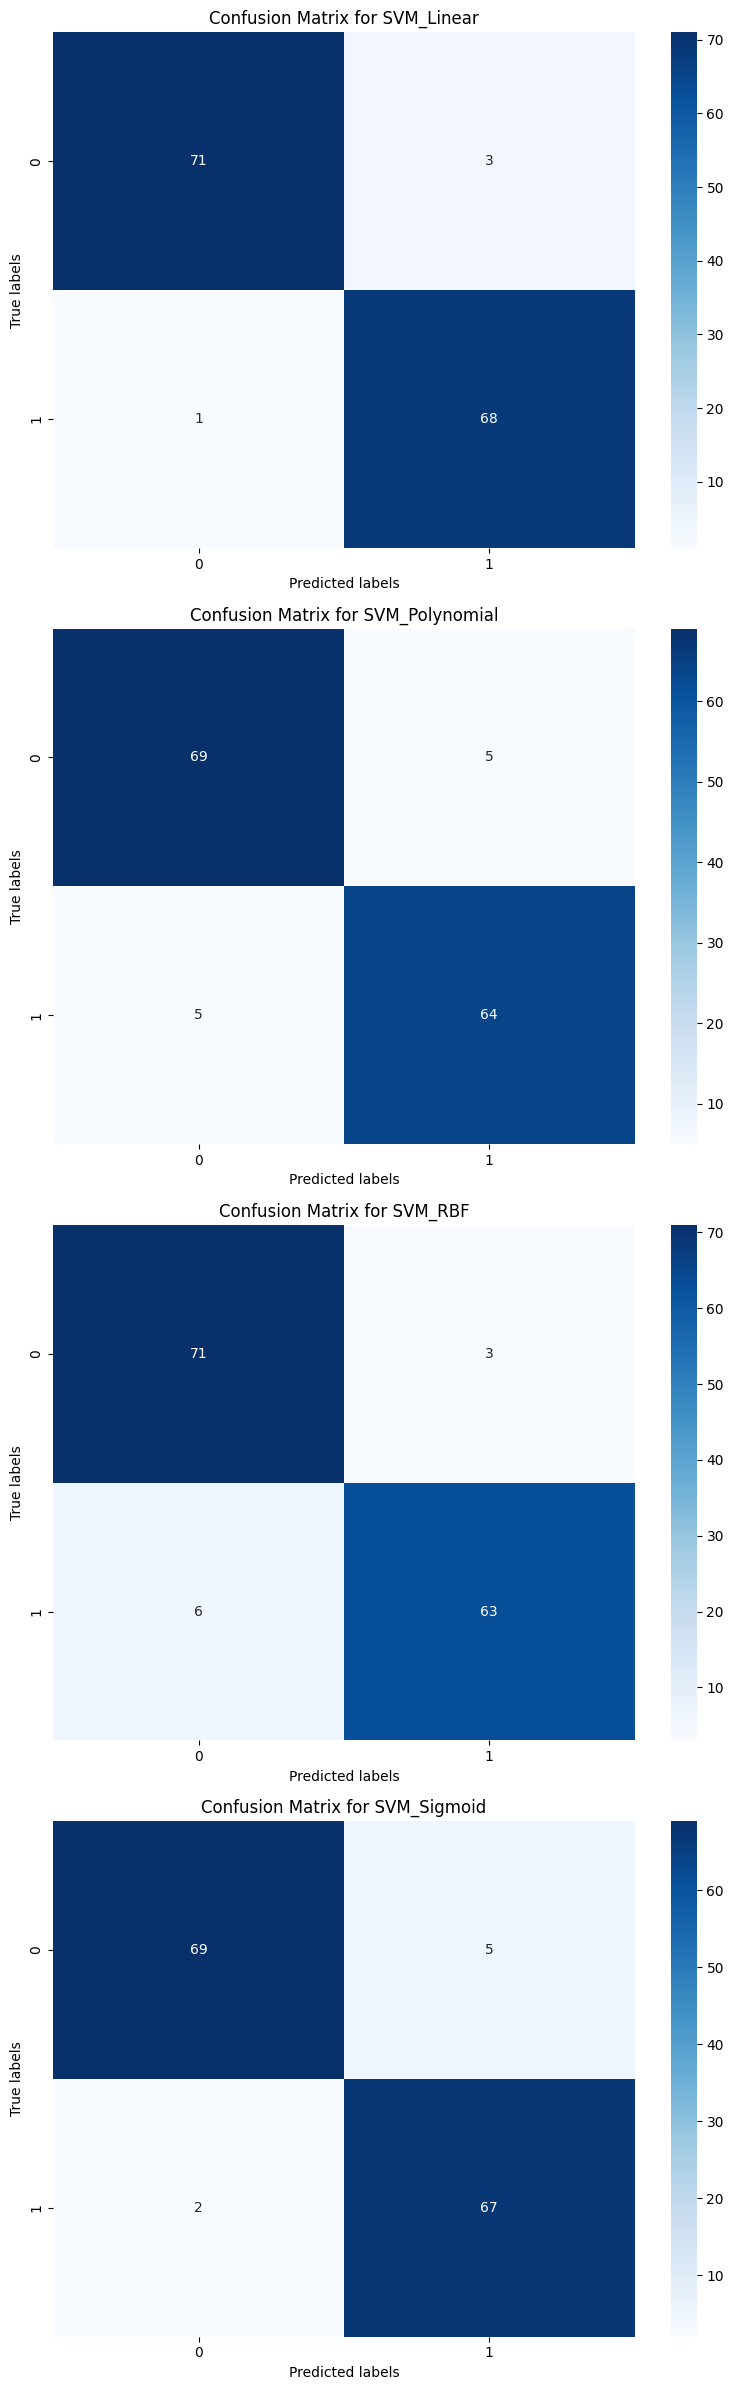

In [82]:
fig, axes = plt.subplots(nrows=len(confusion_matrices), ncols=1, figsize=(8, 6*len(confusion_matrices)))

for i, (model_name, matrix) in enumerate(confusion_matrices.items()):
    ax = axes[i]

    sns.heatmap(matrix, annot=True, cmap="Blues", fmt="d", ax=ax)
    
    ax.set_title(f"Confusion Matrix for {model_name}")
    
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

plt.tight_layout()
plt.show()


En general, los cuatro modelos de SVM tuvieron un rendimiento similar. El SVM linear tuvo el mejor rendimiento general, seguido del SVM sigmoide, el SVM RBF y el SVM polynimial. Sin embargo, las diferencias en el rendimiento fueron pequeñas.

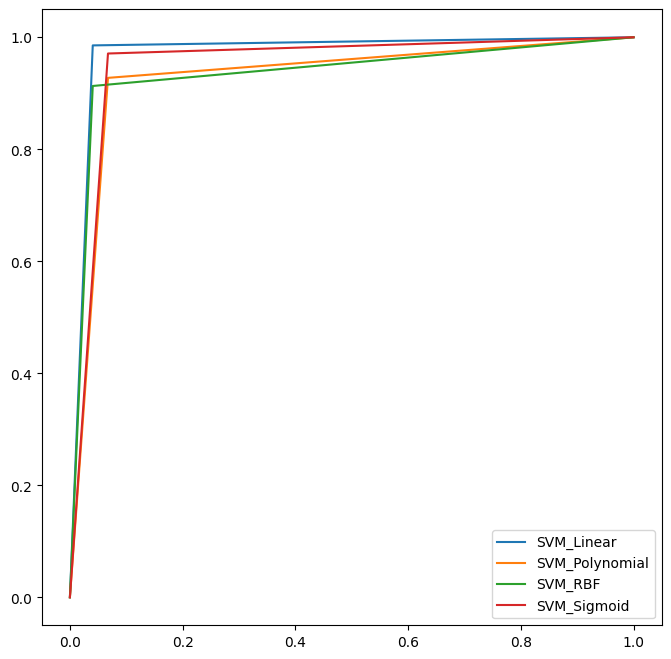

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()

- SVM_Linear: La línea del SVM_Linear es la más baja del gráfico, lo que indica que este algoritmo tiene el peor rendimiento. Esto se debe a que una función de decisión lineal no es capaz de capturar la complejidad de la frontera de decisión entre las clases en este conjunto de datos.

- SVM_Polynomial: La línea del SVM_Polynomial es más alta que la del SVM_Linear, lo que indica que este algoritmo tiene un mejor rendimiento. Esto se debe a que una función de decisión polinomial es capaz de capturar mejor la complejidad de la frontera de decisión.

- SVM_RBF: La línea del SVM_RBF es la más alta del gráfico, lo que indica que este algoritmo tiene el mejor rendimiento. Esto se debe a que el núcleo RBF es capaz de capturar de manera efectiva la no linealidad en los datos.

- SVM_Sigmoid: La línea del SVM_Sigmoid es similar a la del SVM_Polynomial, lo que indica que este algoritmo tiene un rendimiento similar. Sin embargo, el SVM_Sigmoid es generalmente más lento que el SVM_Polynomial.

Conclusiones:

En base a la información proporcionada en el gráfico, se puede concluir que el SVM_RBF es el mejor algoritmo de clasificación para este conjunto de datos específico.